In [47]:
import sys
print(sys.version, sys.executable)
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from datetime import date
from collections import Counter
import re
import string
import os
import praw
import nltk
from nltk.corpus import stopwords
from draftfast import rules
from draftfast.optimize import run
from draftfast.orm import Player
from draftfast.csv_parse import salary_download
from draftfast.settings import OptimizerSettings, CustomRule, PlayerPoolSettings
from draftfast.lineup_constraints import LineupConstraints
from draftfast.csv_parse import salary_download

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

ACTIVE_FILE = './data/active.csv'
REDDIT_PW = os.getenv('RED_PW')
CLIENT_SECRET ='CTtsLidvlHgYMhT4IsBW6Dc-2N8'
CLIENT_ID='QH_iPhx9pfhRPQ'
# print(REDDIT_PW)
# SUBREDDIT = 'cryptocurrency' # 'wallstreetbets' # 
SUBREDDIT = 'fantasyfootball'
print('ready')

3.7.12 (default, Oct 13 2021, 06:53:03) 
[Clang 13.0.0 (clang-1300.0.29.3)] /usr/local/opt/python@3.7/bin/python3.7
ready


In [48]:
players = salary_download.generate_players_from_csvs(salary_file_location=ACTIVE_FILE, game=rules.FAN_DUEL)

In [49]:
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent="my user agent")

In [50]:
def filter_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def get_last_name(p):
    return filter_punctuation(p.name.split(' ')[-1]).lower()

print(players[0].name, " --- ", get_last_name(players[0]))

Cooper Kupp  ---  kupp


In [51]:
player_names = [get_last_name(p) for p in players if p.pos != 'D']
print(player_names[:5])
len(player_names)

['kupp', 'taylor', 'kamara', 'ekeler', 'samuel']


273

In [52]:
def find_players(text, names, count_duplicates=False):
#     https://stackoverflow.com/questions/48025016/regular-expression-matching-stock-ticker?rq=1
    text = filter_punctuation(text)
    words = text.lower().split()
    names = [w for w in words if w in names]
    return Counter(names) if count_duplicates else Counter(set(names))

find_players('Kupp and Samuel are the best this week', player_names)

Counter({'kupp': 1, 'samuel': 1})

In [53]:
SUBMISSION_LIMIT = 20
submissions = reddit.subreddit(SUBREDDIT).hot(limit=SUBMISSION_LIMIT)
submissions = list(submissions)

In [54]:
for s in submissions[:10]:
    print(s.title)
    
print(len(submissions))

Official: [Index] - Fri Morning, 12/31/2021
Tyler Lockett describing his battle with COVID. Says he was very exhausted, could barely move, chest hurting, throat hurting, anxiety, vomiting. Had no energy, barely eating – says he lost like 8 pounds. Also had some breathing issues. "That wasn't fun at all."
Steelers QB Ben Roethlisberger told reporters today that Monday night’s game vs. Browns will likely be his final game at Heinz Field. "I don’t ever speak in guarantees, but signs are pointing that this could be it."
AB Contract Incentive Tracker
Cam Akers considered unlikely to play Week 17
Championship Underdogs: Who are you playing to swing for the fences?
Bucs WR Antonio Brown downgraded to did not participate Thursday with an ankle injury.
Fred Warner says Trey Lance actually frustrated him early in season on scout team because he wasn't taking risks, was tucking/running a lot. 49ers defense wasn't getting work it needed. Warner pulled Lance aside, told him it's OK to take risks. S

In [55]:
cnt = Counter()
COMMENT_LEVELS = 5

for i, submission in enumerate(submissions):
    print('\n',i+1,submission.title)
    submission.comments.replace_more(limit=COMMENT_LEVELS) #limit=None (keeps all subtrees of comments, 0 ignores)
    submission.comment_sort = "top" # one of (confidence, top, new, controversial, old, random, qa, live, blank)
    comments = submission.comments.list()
    print('comments', len(comments))
    names = Counter()
    for comment in comments:
        text = comment.body or ''
        names += find_players(text, player_names)
        # print('text preview: ', text[:100])
    print('names', names)
    cnt += names


 1 Official: [Index] - Fri Morning, 12/31/2021
comments 0
names Counter()

 2 Tyler Lockett describing his battle with COVID. Says he was very exhausted, could barely move, chest hurting, throat hurting, anxiety, vomiting. Had no energy, barely eating – says he lost like 8 pounds. Also had some breathing issues. "That wasn't fun at all."
comments 68
names Counter({'cooks': 4, 'williams': 3, 'lockett': 2, 'cook': 2, 'golladay': 1, 'hill': 1, 'michel': 1})

 3 Steelers QB Ben Roethlisberger told reporters today that Monday night’s game vs. Browns will likely be his final game at Heinz Field. "I don’t ever speak in guarantees, but signs are pointing that this could be it."
comments 225
names Counter({'claypool': 11, 'rudolph': 7, 'wilson': 4, 'johnson': 3, 'kupp': 3, 'love': 3, 'harris': 2, 'stafford': 2, 'gaskin': 2, 'robinson': 1, 'allen': 1, 'lance': 1, 'hill': 1, 'mayfield': 1, 'williams': 1, 'murray': 1, 'lamb': 1, 'jefferson': 1, 'brown': 1, 'higgins': 1, 'carr': 1, 'huntley': 1, '

In [56]:
data = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
x_label = 'name'
data = data.rename(columns={'index': x_label, 0: "count"})
data = data.sort_values(by='count', ascending=False)
data

,name,count
52,swift,180
23,brown,127
100,waddle,100
16,kupp,98
46,penny,94
...,...,...
93,pringle,1
109,ryan,1
111,mcnichols,1
118,abdullah,1


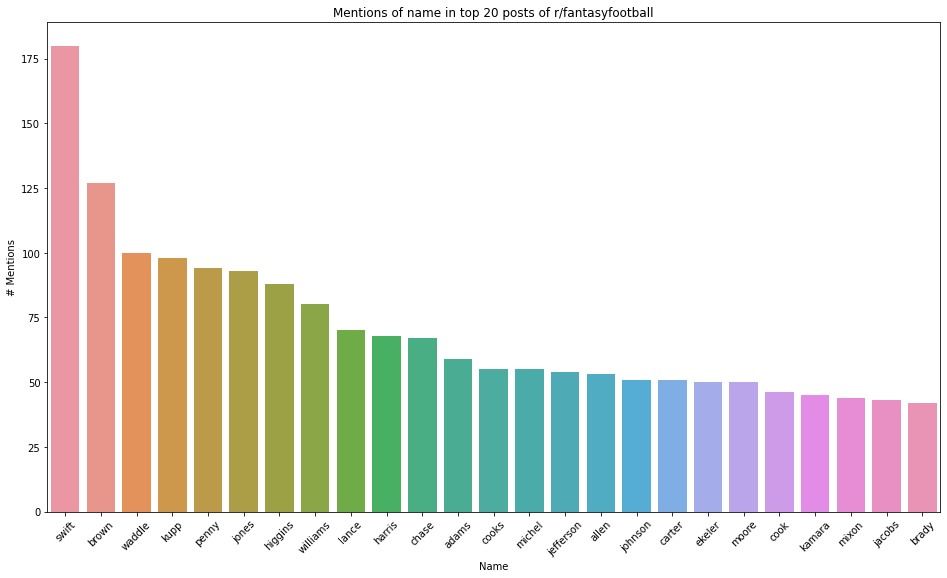

In [57]:
plt.figure(figsize=(16,9))

ax = sns.barplot(x=x_label, y='count',data=data[:25])
plt.xlabel(x_label.capitalize())  
plt.ylabel('# Mentions')  
plt.title(f"Mentions of {x_label} in top {SUBMISSION_LIMIT} posts of r/{SUBREDDIT}")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# TODO: render full name in chart